<a href="https://colab.research.google.com/github/ArtemBurenok/CryproClustering/blob/main/Cripto_clastering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install python-binance
!pip install tsfel
!pip install MulticoreTSNE
!pip install tslearn

     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 103 kB 15.9 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 1.1 MB 51.9 MB/s 
     |████████████████████████████████| 288 kB 47.3 MB/s 
     |████████████████████████████████| 94 kB 2.9 MB/s 
     |████████████████████████████████| 271 kB 45.6 MB/s 
     |████████████████████████████████| 144 kB 54.7 MB/s 
     |████████████████████████████████| 46 kB 2.5 MB/s 
     |████████████████████████████████| 792 kB 16.9 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 375 kB 54.6 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully u

  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp37-cp37m-linux_x86_64.whl size=68517 sha256=6d22dcab763b21337f7bbe508a8a5b378af38ef223d82f677a77ab950ffa32fc
  Stored in directory: /root/.cache/pip/wheels/80/47/df/c0d66e9f775f33281c422a1964de86a59c47f93bb8c37643e3
Successfully built MulticoreTSNE
     |████████████████████████████████| 793 kB 7.6 MB/s 


In [4]:
import numpy as np
import pandas as pd 
import warnings

warnings.filterwarnings("ignore")

import time
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.clustering import silhouette_score

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

from binance.client import Client

import tsfel
from MulticoreTSNE import MulticoreTSNE as TSNE

In [ ]:
api_key = "api_key"
secret_key = "secret_key"

client = Client(api_key, secret_key)

## Загрузка данных о каждой монете

In [ ]:
def coins_data_USDT(start_date=0, end_date=0, interval=0, only_close=True):
    data = []
    used_symbols = []
    timesteps = []

    info = client.get_all_tickers()
    info = pd.DataFrame(info)['symbol']
    symbols = info[(info.str.contains('.*USDT\\b', regex=True) * (~info.str.contains('.*DOWNUSDT\\b', regex=True)) * (~info.str.contains('.*UPUSDT\\b', regex=True)) * (~info.str.contains('.*USD[^T].', regex=True)))].reset_index(drop=True)

    del info

    if only_close:
        i_data = np.array(client.get_historical_klines(symbols[0], interval, start_date, end_date), dtype=np.float64)[:, [4]]
    else:
        i_data = np.array(client.get_historical_klines(symbols[0], interval, start_date, end_date), dtype=np.float64)[:, [0, 1, 2, 3, 4, 7]]
    
    timesteps.append(i_data[:, 0])
    data.append(i_data[:, 1:])
    used_symbols.append(symbols[0])

    length = len(i_data)

    for symbol in symbols[1:]:
        if(len(client.get_historical_klines(symbol, interval, start_date, end_date)) == length):
            if only_close:
                i_data = np.array(client.get_historical_klines(symbol, interval, start_date, end_date), dtype=np.float64)[:, [0, 4]]
            else:
                i_data = np.array(client.get_historical_klines(symbol, interval, start_date, end_date), dtype=np.float64)[:, [1, 2, 3, 4, 7]]
            data.append(i_data)
            used_symbols.append(symbol)

    return np.array(data), np.array(used_symbols), np.array(timesteps)

## Отображение графиков для каждой монеты, которые находятся в классах

In [ ]:
def plot_cluster_tickers(current_cluster, symbols):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0] / 4)), 
        4, 
        figsize=(15, 3 * int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, row in enumerate(current_cluster):
        ax[index].plot(row)
        ax[index].set_title(symbols[index])
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

## Кластеризация и визуализация данных

In [1]:
def clustering(data, symbols, clustering_method='tskmeans_euclidean', scaler='minmax', n_clusters=2):
    only_close = len(data.shape)==2
    
    if (scaler == 'minmax'):
        scaler = TimeSeriesScalerMinMax()
        data_scaled = scaler.fit_transform(data)
    elif(scaler == 'standart'):
        scaler = TimeSeriesScalerMeanVariance()
        data_scaled = scaler.fit_transform()
    else:
        print("uncorrect scaler")
        return 0
    
    if (clustering_method=='tskmeans_euclidean'):
        clusterer = TimeSeriesKMeans(n_clusters, n_init=100, metric='euclidean', n_jobs=-1)
    elif (clustering_method=='kmeans'):
        if (not(only_close)):
            data_scaled = data_scaled.swapaxes(2, 1).reshape(data_scaled.shape[0], -1)
        clusterer = KMeans(n_init=100, n_clusters=n_clusters)

    clusterer.fit(data_scaled)
    clusters = clusterer.predict(data_scaled)
    clusters_names = ['Clusters without BTC', 'Clusters without BTC']
    clusters_names[clusters[np.where(symbols=='BTCUSDT')[0][0]]] = 'Cluster with BTC'

    for cluster_number in range(n_clusters):
        print('===============================================')
        print(f"Cluster name: {clusters_names[cluster_number]}")
        print('===============================================')

        if (only_close == False):
            plot_cluster_tickers(data[(clusters == cluster_number).nonzero(), :, 0][0, :, :], symbols[(clusters == cluster_number).nonzero()])
        else:
            plot_cluster_tickers(data[(clusters == cluster_number).nonzero()], symbols[(clusters==cluster_number).nonzero()])
    
    return data_scaled, symbols, clusters

## Загрузка данных

In [ ]:
coins, symbols, timesteps = coins_data_USDT('10 Aug, 2021', '18 Oct, 2021', Client.KLINE_INTERVAL_1HOUR, only_close=False)

In [ ]:
pd.DataFrame(coins[3])

0       1       2       3             4
0     46.491  46.768  45.656  45.994  8.845749e+05
1     45.975  46.100  45.612  46.051  4.917505e+05
2     46.032  46.497  45.877  46.470  5.262007e+05
3     46.450  46.506  45.800  45.986  5.731673e+05
4     45.933  46.218  45.774  45.857  4.398184e+05
...      ...     ...     ...     ...           ...
1646  43.330  43.330  41.530  42.100  2.937639e+06
1647  42.100  42.800  42.010  42.770  5.935433e+05
1648  42.800  43.240  42.780  43.070  9.061645e+05
1649  43.070  43.310  42.930  43.260  4.180876e+05
1650  43.260  43.540  43.020  43.410  5.611348e+05

[1651 rows x 5 columns]

## Kmeans

In [ ]:
!pip install --upgrade matplotlib

     |████████████████████████████████| 10.3 MB 5.8 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Cluster name: Cluster with BTC


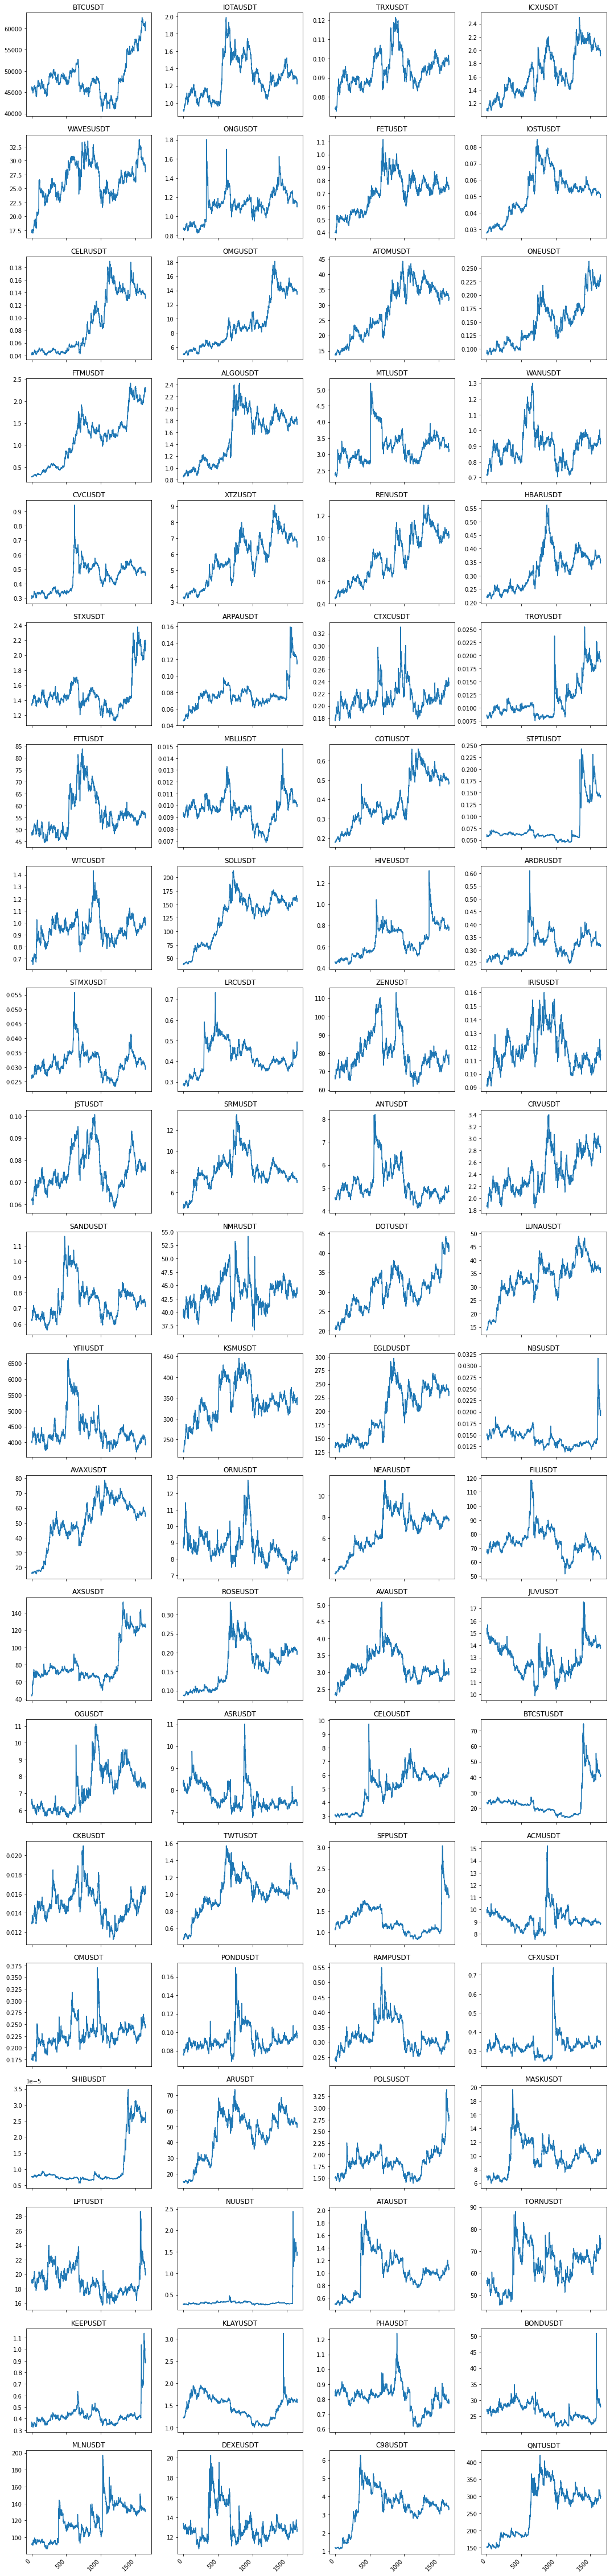

Cluster name: Clusters without BTC


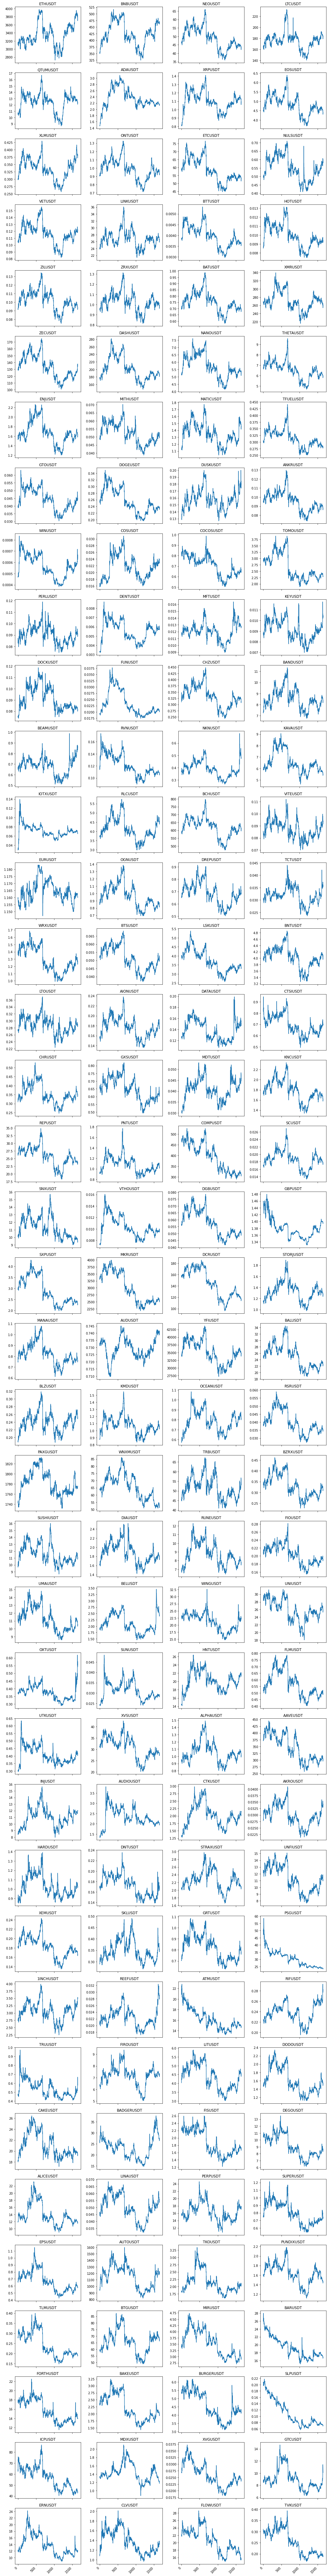

In [ ]:
coins_scaled_flattened, symbols, clasters_kmeans =  clustering(coins, symbols, clustering_method='kmeans')

## Time series KMeans

Cluster name: Clusters without BTC


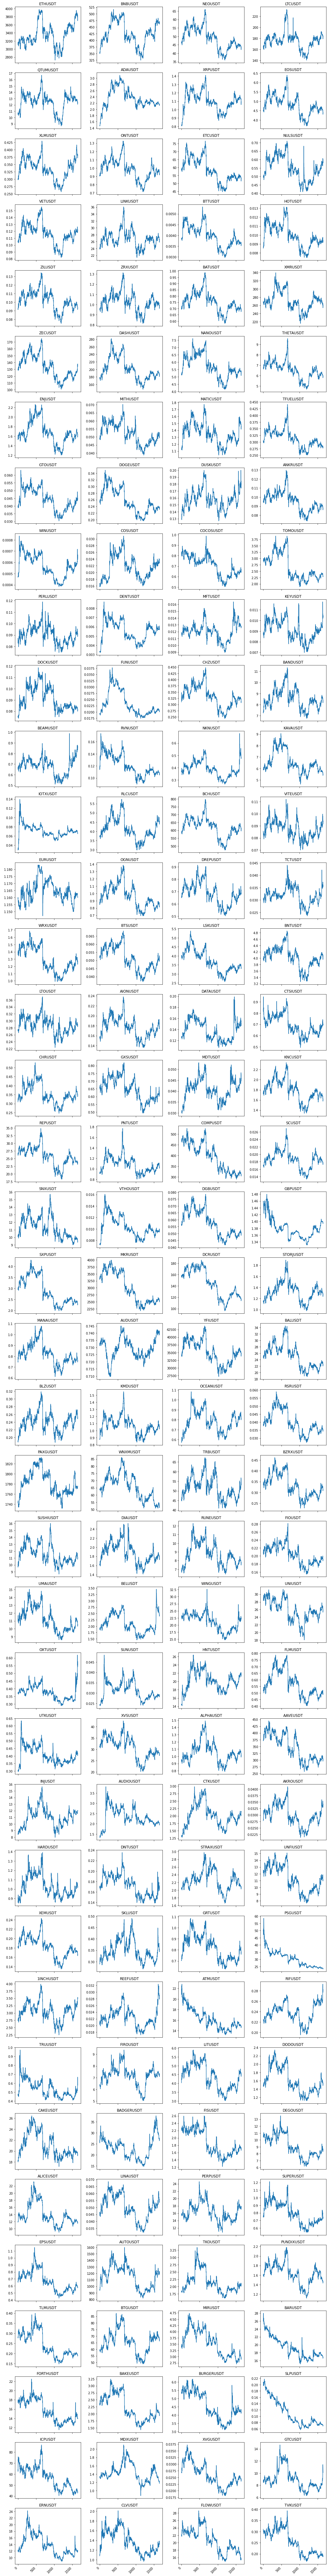

Cluster name: Cluster with BTC


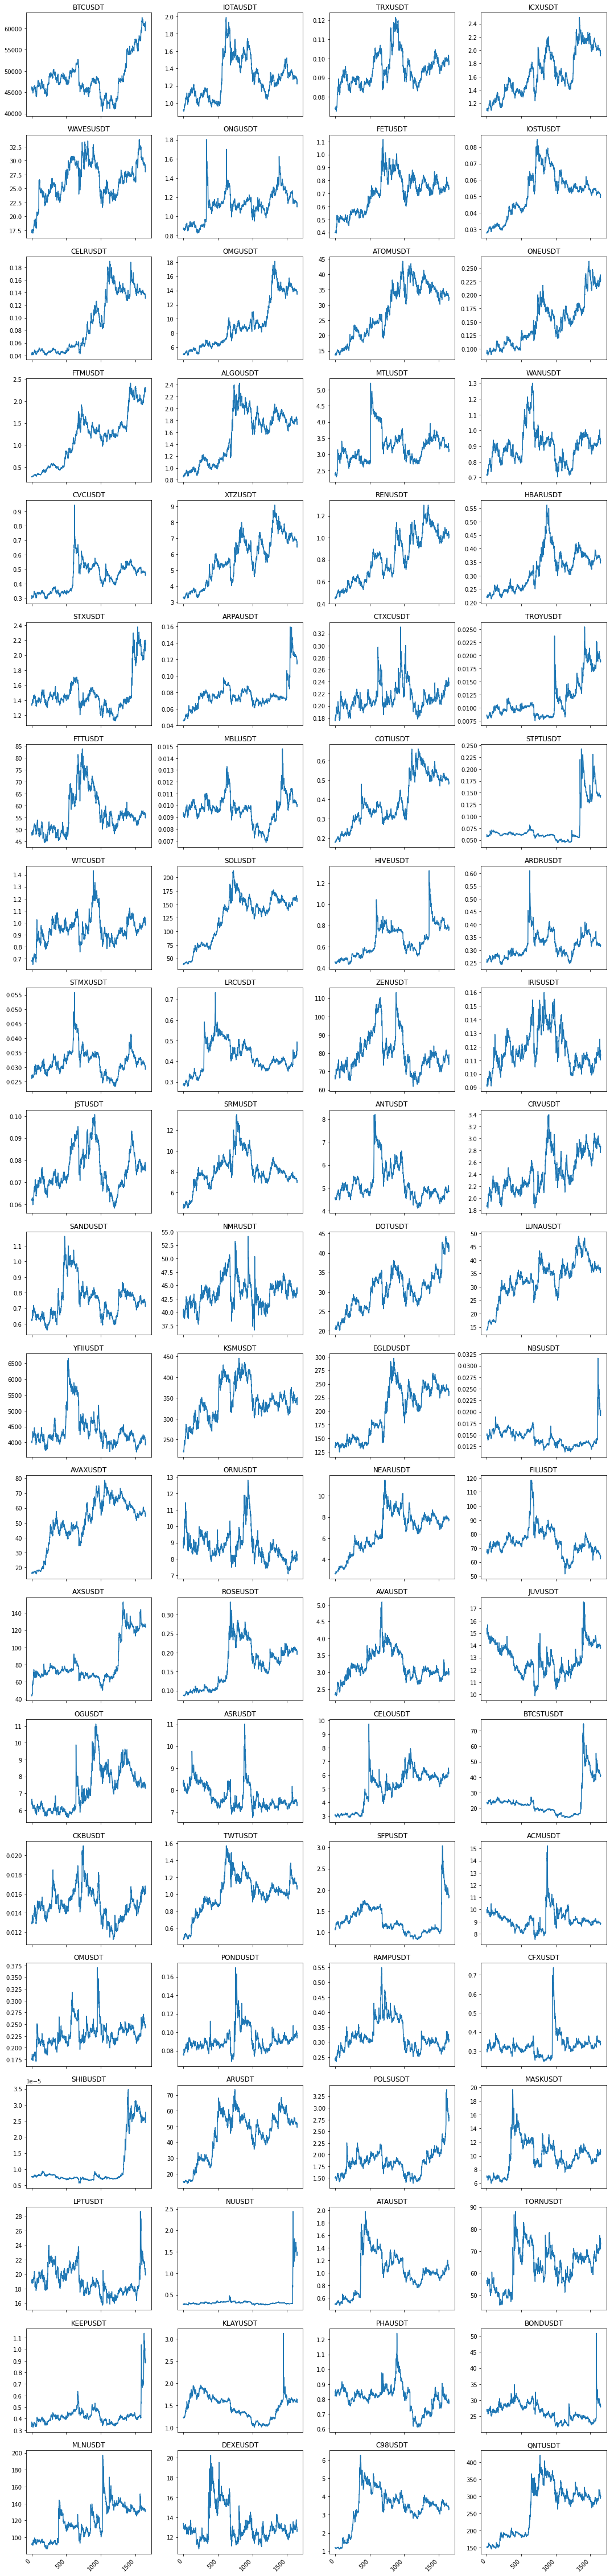

In [ ]:
coins_scaled_flatten, symbols, clasters_TSKMeans = clustering(coins, symbols, clustering_method='tskmeans_euclidean')